In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import dateparser
import copy

1) Log file is loaded

In [2]:
file = open("log.txt", "r") 
lines = file.readlines()
for l in range(3): print(lines[l][:-1])

156.15.13.173 [01/Jan/2018:11:13:49 +0100] "GET AddProduct.html HTTP/1.0" 200 2356
176.247.135.49 [01/Jan/2018:11:18:07 +0100] "GET Shop.html HTTP/1.0" 200 7466
176.247.135.49 [01/Jan/2018:11:19:05 +0100] "GET AddProduct.html HTTP/1.0" 200 2356


2) Class "Request" parses and keeps data of a single requests. Complete the TODO, where a given "line" (string) should be parsed in order to dervie the ip of the host making the request, time of the request (in seconds), and target page (name).

In [3]:
class Request:
    def __init__(self, line):
        # TODO DO PARSING HERE
        fields = line.split(" ")

        self.ip = fields[0]
        
        timeFields = fields[1].split(":")
        # convert hours + minutes + seconds -> total number of seconds
        self.time = int(timeFields[1]) * 3600 + int(timeFields[2]) * 60 + int(timeFields[3]) 
        self.page = fields[4]
        
    def __repr__(self):
        return self.ip + "     " +  str(datetime.timedelta(seconds=self.time)) + " -> " + self.page


3) Each line of log.txt is parsed and the Request objects are added to the list

In [4]:
reqs = [Request(line) for line in lines]
for l in range(10): print(reqs[l]) 

156.15.13.173     11:13:49 -> AddProduct.html
176.247.135.49     11:18:07 -> Shop.html
176.247.135.49     11:19:05 -> AddProduct.html
176.247.135.49     11:29:05 -> Summary.html
69.84.30.199     11:43:59 -> Shop.html
69.84.30.199     11:45:16 -> AddProduct.html
57.116.45.120     11:46:45 -> AddProduct.html
69.84.30.199     11:50:36 -> Summary.html
69.84.30.199     11:52:38 -> Payment.html
26.19.183.202     11:53:11 -> AddProduct.html


# Exercise

Your task is to analyze the log file. You should indentify the users and sessions. Then, compute the following: <br>
3.1) the number of sessions (should be 1000 :) ), <br>
3.2) the number of users, <br>
3.3) the average number of sessions per one user <br>
3.4) use the distribution plot to visualize the sessions' lengths (minutes);  <br>
3.5) use the distribution plot to visualize the sessions' lengths (the number of requests) <br>
3.6) use the distribution plot to visualize sessions' starting times (hours). <br>
3.7) which web page is the most common entry point?; for each page plot the number of times it has been an entry page,  <br>
3.8) which web page is the most common departure point?; for each page plot the number of times the user stopped a session while being on this page, <br>
3.9) for each page plot the average time the user stayed on this page <br>
3.10) print the fist 10 sessions (paths). <br>

You may find the following classes helpful and data.

In [5]:
class Session:
    def __init__(self):
        self.startTime = 0
        self.stopTime = 0
        self.requests = []
        
    def __repr__(self):
        #print("SESSION")
        #print(self.startTime)
        #print(self.stopTime)
        STR = ""
        for r in self.requests:
            #print(r)
            STR += ("  " + r.page + "    " + str(datetime.timedelta(seconds=r.time)) + "\n")
        return STR
    def __getitem__():
        return self
    
    def durationInMinutes(self):
        return (self.stopTime - self.startTime) / 60
    
    def numberOfRequests(self):
        return len(self.requests)
    
    def getStartingTimeHrs(self):
        return self.startTime / 3600
    
    def getTimeSpentOnPage(self, pageNum):
        return self.requests[pageNum + 1].time - self.requests[pageNum].time
    
class Computer:
    def __init__(self, ip):
        self.ip = ip
        self.sessions = []
    def __repr__(self):
        return self.ip
    def sumOfSessions(self):
        return len(self.sessions)
    
    
PAGES = ["Shop.html", "AddProduct.html", "Summary.html", "Payment.html","About.html", "Contact.html"]

LINKS = [[1, 4],
         [2,4],
         [3],
         [],
         [1,5],
         []]
    

#Useful functions
def findUserByIp(ipAddr, users):
    for usr in users:
        if ipAddr == usr.ip:
            return usr
    return Computer(ip = ipAddr)

def timeExceeded(session, currentRequest):
    if (currentRequest.time - session.endTime) > 34*60:
        return True
    return False

def lastPage(currentRequest):
    if len(LINKS[PAGES.index(currentRequest.page)]) == 0:
        return True
    return False

def hasLink(session, currentRequest):
    if len(session.requests) == 0:
        return True
    if PAGES.index(currentRequest.page) in LINKS[PAGES.index(session.requests[-1].page)]:
        return True
    return False

In [6]:
reqsCopy = copy.copy(reqs)
users = []
sessions = []

while len(reqsCopy) != 0:
    req = reqsCopy[0]
    user = findUserByIp(req.ip, users)
    if user not in users:
        users.append(user)
        
    toRemoveList = []
    
    sess = Session()
    sess.startTime = req.time
    sess.endTime = req.time
    for j in reqsCopy:
        if timeExceeded(sess, j):
            break
        if j.ip == req.ip:
            if not hasLink(sess, j):
                break
            sess.stopTime = j.time
            sess.requests.append(j)
            toRemoveList.append(j)
            if lastPage(j):
                break
    
    for elem in toRemoveList:
        reqsCopy.remove(elem)
    user.sessions.append(sess)
    sessions.append(sess)

In [7]:
#3.1
numOfSessions = 0
for user in users:
    numOfSessions += user.sumOfSessions()

#3.2
numOfUsers = len(users)

#3.3
avgSessions = numOfSessions/numOfUsers

#3.4-3.9
session_lengths_minutes = []
session_lengths_requests = []
session_starts_hours = []
session_entry_points = np.zeros(len(PAGES))
session_departure_points = np.zeros(len(PAGES))
page_visits = np.zeros(len(PAGES))
page_time_spent = np.zeros(len(PAGES))

for user in users:
    for session in user.sessions:
        session_lengths_minutes.append(session.durationInMinutes())
        session_lengths_requests.append(session.numberOfRequests())
        session_starts_hours.append(session.getStartingTimeHrs())
        session_entry_points[PAGES.index(session.requests[0].page)] += 1
        session_departure_points[PAGES.index(session.requests[-1].page)] += 1
        for i in range(len(session.requests) - 1):
            page_visits[PAGES.index(session.requests[i].page)] +=1
            page_time_spent[PAGES.index(session.requests[i].page)] += session.getTimeSpentOnPage(i)

pageAverage = []
for t,v in zip(page_time_spent, page_visits):
    if v != 0:
        pageAverage.append(t / v)
    else:
        pageAverage.append(0)

Number of sessions:  1001
Number of users:  391
Average number of sessions per user:  2.5601023017902813


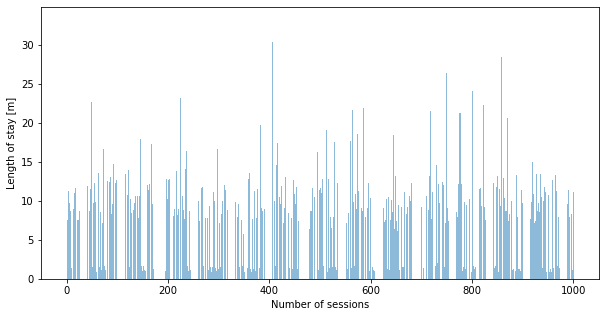

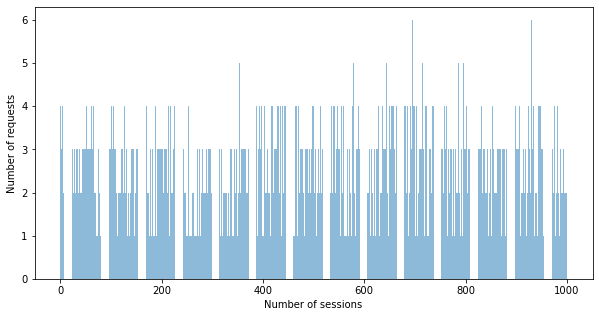

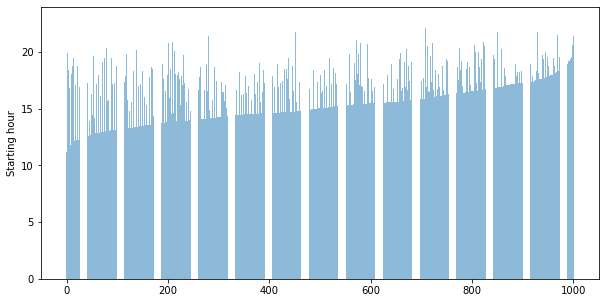

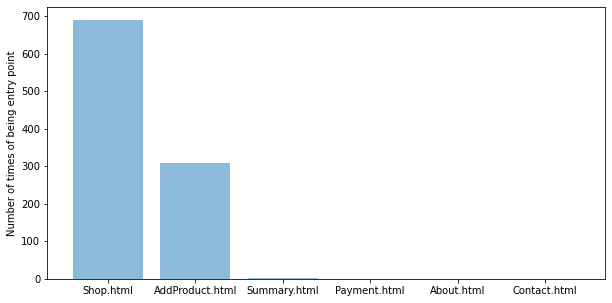

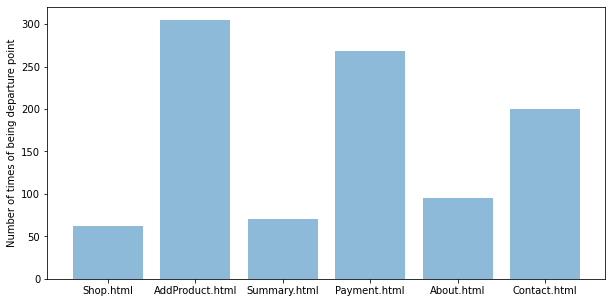

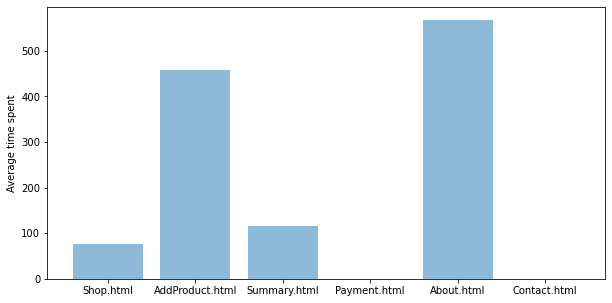

In [8]:
#plot distribution
#count, bins, ignored = plt.hist(session_lengths_minutes, 50, alpha=0.5, normed=True)
#plt.plot()

print("Number of sessions: ", numOfSessions)
print("Number of users: ", numOfUsers)
print("Average number of sessions per user: ", avgSessions)

x_axis = np.arange(numOfSessions)
plt.figure(figsize=(10,5))
plt.bar(x_axis, session_lengths_minutes, align='center', alpha=0.5)
plt.xlabel("Number of sessions")
plt.ylabel("Length of stay [m]")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(x_axis, session_lengths_requests, align='center', alpha=0.5)
plt.xlabel("Number of sessions")
plt.ylabel("Number of requests")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(x_axis, session_starts_hours, align='center', alpha=0.5)
plt.ylabel("Starting hour")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(PAGES, session_entry_points, align='center', alpha=0.5)
plt.ylabel("Number of times of being entry point")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(PAGES, session_departure_points, align='center', alpha=0.5)
plt.ylabel("Number of times of being departure point")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(PAGES, pageAverage, align='center', alpha=0.5)
plt.ylabel("Average time spent")
plt.show()

In [9]:
print("10 first sessions' paths\n")

i = 0
while i < 10:
    reqList = sessions[i].requests
    for req in reqList:
        print(req.page, end="")
        if req == reqList[-1]:
            print()
        else:
            print(" => ", end="")
    i += 1

10 first sessions' paths

AddProduct.html
Shop.html => AddProduct.html => Summary.html
Shop.html => AddProduct.html => Summary.html => Payment.html
AddProduct.html => Summary.html => Payment.html
AddProduct.html => About.html => Contact.html
Shop.html => AddProduct.html
Shop.html => About.html
Shop.html => About.html => Contact.html
Shop.html
AddProduct.html
